In [1]:
%matplotlib inline

import numpy as np
from scipy import integrate
from scipy.spatial import distance
from scipy.spatial import cKDTree

from nolitsa import dimension

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

-----
# MY RUNGE-KUTTA

Manual implementation

**Lorenz system**

Model the chaotic time series as solutions of dynamic Lorenz equation with parameters:  
$ \sigma = 10, \ \beta = 8/3 $  for both cases  
and $r = 26 \ (partly \ chaotic) $ for the first case and $r = 28 \ (fully \ chaotic) $ for second case

\begin{cases} 
              \dot x = \sigma (y - x) \\ 
              \dot y = rx - y - xz \\      
              \dot z = xy - bz
\end{cases}


**Runge-Kutta method 4rth order:**

For the equation $ \dot x = F(x,t) $, we compute slope elements and the average them with weights:

$$ k_{1} = F(t,x) \\
   k_{2} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{1}} {2}) \\
   k_{3} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{2}} {2}) \\
   k_{2} = F(t +  {\delta t}, x + {\delta t *k_{3}})
$$
$$ \\ $$
$$
\\ 
\delta x = \frac {\delta t (k_{1} + 2k_{2} + 2k_{3} + k_{4})} {6} \\
x(t + \delta t) = x(t) + \delta x
$$


In [4]:
def deriviation_step(initial_state, derivative, dt):
    """
    Compute one evaluation step
    """
    
    # evaluation of state
    state = {}
    
    if not derivative:
        state["x"] = initial_state["x"] 
        state["y"] = initial_state["y"] 
        state["z"] = initial_state["z"] 
    else:
        state["x"] = initial_state["x"] + derivative["dx"] * dt
        state["y"] = initial_state["y"] + derivative["dy"] * dt
        state["z"] = initial_state["z"] + derivative["dz"] * dt
        
    # evaluation of derivative
    derivative_next_step = {}
    
    derivative_next_step["dx"] = sigma * (state["y"] - state["x"])
    derivative_next_step["dy"] = rho * state["x"] - state["y"] - state["x"] * state["z"]
    derivative_next_step["dz"] = state["x"] * state["y"] - beta * state["z"]
    
    return derivative_next_step
    
def RK_integration(state, dt):
    """
    Runge-Kutta integration of the 4th order at a time `t` with a state `state` 
    with the step `dt`
    """
    
    # Prepare 1,2,3,4 - order derivatives for the final "best" derivative,
    # gained as 4 first elements of the Taylor's approximation
    
    # Random initialization of defivatives(probably will have to moove)
    derivative = dict({"dx": np.random.normal(),
                       "dy": np.random.normal(),
                       "dz": np.random.normal()})
    rk1 = deriviation_step(initial_state=state,
                           derivative=None,
                           dt=dt*0)
    
    rk2 = deriviation_step(initial_state=state, 
                           derivative=rk1,
                           dt=dt*0.5
                           )
    
    rk3 = deriviation_step(initial_state=state, 
                           derivative=rk2,
                           dt=dt*0.5)
    
    rk4 = deriviation_step(initial_state=state,
                           derivative=rk3,
                           dt=dt)
    
    # When all derivatives are ready, it's time to construct Rung-Kutta derivative
    # !!!! DOUBLE CHECK THE TAYLOR'S APPROXIMATIONS !!!!
    dxdt = (1 / 6) * (rk1["dx"] + 2* rk2["dx"] + 2 * rk3["dx"] + rk4["dx"])
    dydt = (1 / 6) * (rk1["dy"] + 2* rk2["dy"] + 2 * rk3["dy"] + rk4["dy"])
    dzdt = (1 / 6) * (rk1["dz"] + 2* rk2["dz"] + 2 * rk3["dz"] + rk4["dz"])
    
    state["x"] = state["x"] + dxdt * dt
    state["y"] = state["y"] + dydt * dt
    state["z"] = state["z"] + dzdt * dt
    return state

## Generation of time series

$\rho = 26$

In [5]:
beta = 8 / 3
rho = 26
sigma = 10

initial_state = dict({"x": 0.62225717 ,
                   "y": -0.08232857 ,
                   "z": 30.60845379})

ode_solutions = []
for iteration in range(0, int(1e6)):
    state_t = RK_integration(initial_state, dt=0.1)
    ode_solutions.append(list(state_t.values()))
result = np.array(ode_solutions)
series_26 = result[:, 0]

$\rho = 28$

In [6]:
beta = 8 / 3
rho = 28
sigma = 10

initial_state = dict({"x": 0.62225717 ,
                   "y": -0.08232857 ,
                   "z": 30.60845379})

ode_solutions = []
for iteration in range(0, int(1e6)):
    state_t = RK_integration(initial_state, dt=0.1)
    ode_solutions.append(list(state_t.values()))
result = np.array(ode_solutions)
series_28 = result[:, 0]

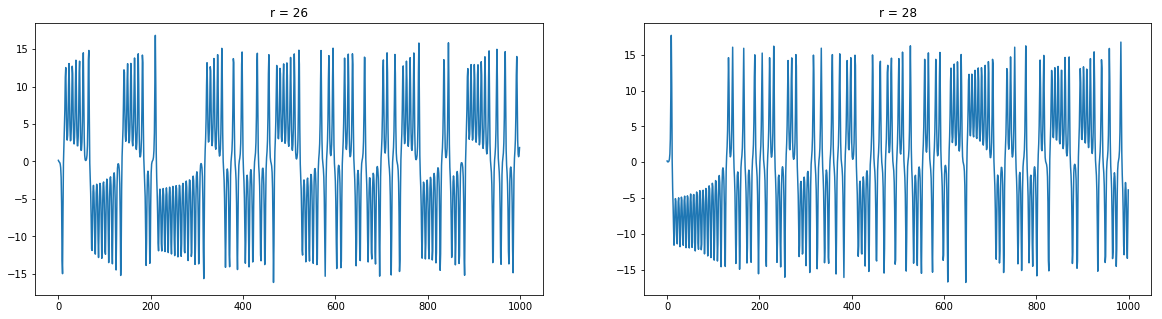

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,5);
ax1.plot(series_26[:1000]);
ax1.set_title("r = 26");
ax2.plot(series_28[:1000]);
ax2.set_title("r = 28");

-----
## Largest lyapunov exponent by Rosenstein method  
Advantages: robust to changes in embedding dimension, size of dataset, reconstruction delay and noise level  
Positive lyapunov characteristics points on the chaotic nature of the time series  
**Algorithm:**
- Estimate $m$ using FNN and mean period using FFT (find all harmonics and average them)
- Reconstruct the attractor dynamics $\textbf{X}$ from a single time series:  
$ $$\textbf{X}$ is a matrix, where each row - phase-space vector: $(X_{1},..., X_{M})^{T}$,  
$ $where $X_{i}$ is the state of the system at descrete time $i$.  
$ $For the $N$-point time series $(x_{1},..., x_{N})$, $X_{i}$ is given by $(x_{i}, x_{i+1},..., x_{i + (m-1)})$  
$ $Here $m$ is embedding dimension. So $\textbf{X}$ is $[M \times m]$ matrix and $M=N-(m-1)$
- For each $X_{j}$ in $\textbf{X}$ find nearest neighbor $X_{\hat j}$, so that $d_{j}(0)=min(||X_{j} - X_{\hat j}||)$,  
$ $**But** distance between $j$ and $\hat j$ should be bigger than mean period of the siries(temporal separation)
- For each $X_{j}$ we need to calculate divergency after one tick: $d_{j}(1) = ||X_{j} - X_{\hat j} ||$ and calculate a ratio: $ln \frac {d_{j}(1)} {d_{i}(0)}$
- When we have calculated $ln \frac {d_{j}(1)} {d_{i}(0)}$ for each neighbor's pair, sum them up apply this multiplications/divisions to get
- ~~Least Squares to find best parameters of equation~~. No least square fitting - just average all logarithms: $\lambda_{1} = \sum_{j=1}^{M-1} ln(\frac {d_{j}(1)} {d_{j}(0)}) $

ДОЛЖНЫ ЛИ ПРЕСАТЬСЯ Z - ВЕКТОРА


In [8]:
class Lyapunov:
    """
    Class which emplements resenshein algorithm
    """
    def __init__(self, i, m, J, k):
        """
        
        """
        self.i = i
        self.m = m
        self.J = J
        self.k = k
        
    def _reconstruct(self, ts):
        """
        """
        ts_length = ts.shape[0]
        n_samples = ts_length // (self.m + self.J)
        ts = ts[:n_samples * (self.m + self.J)]
        ts_reconstructed = ts.reshape((n_samples, self.m + self.J))
        if self.J > 0:
            ts_reconstructed = ts_reconstructed[:, :-self.J]
        return ts_reconstructed
    
    def _fit_kd_tree(self, data):
        kdt = cKDTree(data=data)
        return kdt

    def _generator(self, data, kdtree):
        data_length = len(data)
        for index in range(data_length-1):
            element = data[index]
            distances, neighbor_index = kdtree.query(x=element, k=self.k)
            neighbor_index = neighbor_index[self.k - 1]
            distance_1 = distances[self.k - 1]
            if neighbor_index < (data_length - 1):
                pair_j_1 = data[index + 1]
                pair_j_2 = data[neighbor_index + 1]
                distance_2 = distance.euclidean(u=pair_j_1, v=pair_j_2)
                if (distance_2 == 0) | (distance_1 == 0) | np.isnan(distance_1) | np.isnan(distance_2):
                    continue
                yield np.log(distance_2 / distance_1)
            else:
                continue
                
    def compute_lyapunov_exponent(self):
        pass
                
            
            

Что делать если какая то из дистанций (distance_1, distance_2) оказывается нулевой?

График

In [17]:
lyap = Lyapunov(i=1, m=5, J=0, k=2)
ts_reconstructed = lyap._reconstruct(series_26)
kdt = lyap._fit_kd_tree(data=ts_reconstructed)
g = lyap._generator(data=ts_reconstructed, kdtree=kdt)
print("Lyapunov exponent for r=26:", sum(g) / ts_reconstructed.shape[0])

Lyapunov exponent for r=26: 0.005800204335524006


In [18]:
lyap = Lyapunov(i=1, m=5, J=0, k=2)
ts_reconstructed = lyap._reconstruct(series_28)
kdt = lyap._fit_kd_tree(data=ts_reconstructed)
g = lyap._generator(data=ts_reconstructed, kdtree=kdt)
print("Lyapunov exponent for r=28:", sum(g) / ts_reconstructed.shape[0])

Lyapunov exponent for r=28: 0.8881479321368929


-----
## Wishart algorithm

The goal is to cluster *z-vectors*

The defenetion of significant cluster $\Omega^{l}$ is: $max\{|p(x_{i}) - p(x_{j})|, \forall i,j\in\Omega^{l} \} \geq h$ where $p(x_{i})=\frac {k}{NV_{k}(x)}$

- Magicly choose the *k* parameter
- For each point find *k* nearest neighbors and calculate distance for k-th nearest neighbor (the sphere radius)
- After constructing the list $K$ of format 

     $$\{x_{1}:[neighbor^{1}_{1},... , neighbor^{1}_{k}, ]\}$$
     $$\{x_{2}:[neighbor^{2}_{1},... , neighbor^{2}_{k}, ]\}$$
     $$ ... $$
     $$\{x_{N}:[neighbor^{N}_{1},... , neighbor^{N}_{k}, ]\}$$
The list must be sorted by the distance to the k-th nearest neigbor. Formally, we name this list a graph $G(Z_{n}, U_{n})$, where $Z_{n}$ are all verticies-neighbors $x_{i}$ and $U_{n}=\{(i,j):d(x_{i}, x_{j}) \leq d_{k}(x_{i}), i \neq j\} $


- After that we launch a cycle on the sorted list of vertices and at each step execute these:
  - Form a new graph $G(Z_{i}, U_{i})$, where $Z_{i} = \{x_{i}, i=\overline{1,...i}\}$ and $U_{i}$ is the sub-entity of $U_{n}$ vergies which are connected to $Z_{i}$. Define connections of the new vertex as edges between new vertex and verticies $Z_{i} \cap K(i)$ 
  - Then, we apply one of the these rules:
    - case $x_{i}$ is isolated: create a new cluster out of it and move on to the next point
    - case $x_{i}$ is only connected to cluster $l$ then:
      - case $l$ is completed, then assign $x_{i}$ to zero cluster
      - case $l$ is not completed, then assign $x_{i}$ to it
    - case $x_{i}$ is connected to several clusters $l_{1},..., l_{t}$
      - case all clusters are completed, then assign $x_{i}$ to zero cluster
      - case number of significant clusters $z(h) \leq t$
        - case $z(h) > 1$ or $l_{1}=0$, then assign  $x_{i}$ to zero cluster, mark significent clusters as completed, and delete all not significant classes
        - case $z(h) \leq 1$ and $l_{1} > 0$, then merge $l_{2},..., l_{t}$ into $l_{1}$
       


In [22]:
def reconstruct(ts, m, J):
    """
    """
    ts_length = ts.shape[0]
    n_samples = ts_length // (m + J)
    ts = ts[:n_samples * (m + J)]
    ts_reconstructed = ts.reshape((n_samples, m + J))
    if J > 0:
        ts_reconstructed = ts_reconstructed[:, :J]
    return ts_reconstructed

reconstructed_ts = reconstruct(ts=series_28, m=4, J=0)

In [201]:
from scipy.special import gamma

class Wilshart:
    """
    """
    def __init__(self, k, h):
        self.k = k
        self.G = np.array([], dtype=int)
        self.h = h
        self.clusters_completenes = set()
        self.significant_clusters = set()
        
    
    def _fit_kd_tree(self, data):
        kdt = cKDTree(data=data)
        return kdt
          
    def _n_dim_ball_volume(self, radius):
        volume = (radius ** self.k) * (np.pi ** (self.k / 2)) / gamma(self.k / 2 + 1)
        return volume * self.k / self.clusters.shape[0]
      
    def _check_cluster_significance(self, cluster, matrix_distances):
        """
        """
        verticies_radiuses = matrix_distances[self.clusters == cluster][:, self.k-1]
        vertex_with_biggest_radius = max(verticies_radiuses)
        vertex_with_smalles_radius = min(verticies_radiuses)
        ball_volume_max = self._n_dim_ball_volume(vertex_with_biggest_radius)
        ball_volume_min = self._n_dim_ball_volume(vertex_with_smalles_radius)
        maximum_difference = abs(ball_volume_max - ball_volume_min)
        if maximum_difference > self.h:
            self.significant_clusters.add(cluster)
        else:
            pass
    
    def _construct_neighbors_matrix(self, data, kdtree):
        zvector_neighbors_distances = np.zeros(shape=(data.shape[0], self.k))
        zvector_neighbors_indexes = np.empty(shape=(data.shape[0], self.k))
        self.clusters = np.zeros(data.shape[0], dtype=int)
        for index, zvector in enumerate(data):
            zvector_neighbors_dist, zvector_neighbors_ind = kdtree.query(x=zvector, k=self.k+1)
            zvector_neighbors_distances[index] = zvector_neighbors_dist[1:]
            zvector_neighbors_indexes[index] = zvector_neighbors_ind[1:]
        # sort matricies
        vertecies_sorted = zvector_neighbors_distances[:, -1].argsort()
        matrix_distances_sorted = zvector_neighbors_distances[vertecies_sorted]
        matrix_indexes_sorted = zvector_neighbors_indexes[vertecies_sorted]
        return matrix_distances_sorted, matrix_indexes_sorted, vertecies_sorted
    
    def _form_new_cluster(self, vertex):
        max_cluster = self.clusters.max() + 1
        self.clusters[vertex] = max_cluster 
        

    
    def _find_connections(self, vertex, vertex_neighbors, matrix_indecies):
        # Check if existing nodes are connected to a new-comming node
        node_in_g_connections = matrix_indecies[self.G]
        vertex_to_g_connections = np.any(a=(node_in_g_connections == vertex), axis=1)
        if vertex_to_g_connections.shape[0] > 0:
            vertex_to_g_connections = self.G[vertex_to_g_connections]
        # Check if new-comming node has neighbors among existing nodes
        for neighbor in vertex_neighbors:
            if neighbor in self.G:
                vertex_to_g_connections = np.append(arr=vertex_to_g_connections, values=neighbor)
        return vertex_to_g_connections
            

    def _form_graph(self, m_d, m_i, v_s):
        """
        """
        for vertex, vertex_neighbors in zip(v_s, m_i):
            vertex_connections = self._find_connections(vertex=vertex, 
                                                        vertex_neighbors=vertex_neighbors,
                                                        matrix_indecies=m_i)
            
            # Check if vertex is isolated
            if len(vertex_connections) == 0:
                self._form_new_cluster(vertex=vertex)
            # If vertex has only one connection, then:
            elif len(vertex_connections) == 1:
                vertex_connection = vertex_connections[0]
                # If cluster is already completed
                if vertex_connection in self.clusters_completenes:
                    self.clusters[vertex] = 0
                # If cluster is not completed
                else:
                    connection_cluster = self.clusters[vertex_connection]
                    self.clusters[vertex] = connection_cluster
                    self._check_cluster_significance(connection_cluster, m_d)
            # If vertex is connected to more than one clusters/vertcies
            else:
                connected_clusters = set(self.clusters[vertex_connections])
                # If all connections are completed cluster, than assign vertex to zero
                if all(map(lambda x: x in self.clusters_completenes, connected_clusters)):
                    self.clusters[vertex] = 0
                # If one of the clusters is zero, or there are more than one significant clusters, 
                # then assign new vertex to zero
                elif (min(connected_clusters) == 0) |\
                     (len(connected_clusters.intersection(self.significant_clusters)) > 1):
                    self.clusters[vertex] = 0
                    insignificant_to_zero = connected_clusters.difference(self.significant_clusters)
                    significant_to_completed = connected_clusters.intersection(self.significant_clusters)
                    self.clusters_completenes = self.clusters_completenes.union(significant_to_completed)
                    for cluster in insignificant_to_zero:
                        self.clusters[self.clusters == cluster] = 0
                # If there is one or less significant class and no zero classes, 
                # then we should collapse all clusters including new-comming node
                # to the oldest cluster(oldest means that it has the biggest density)
                else:
                    oldest_cluster = min(connected_clusters)
                    other_clusters = sorted(list(connected_clusters))[1:]                    
                    for cluster in other_clusters:
                        self.clusters[self.clusters == cluster] = oldest_cluster
                    self.clusters[vertex] = oldest_cluster
                    
            self.G = np.append(arr=self.G, values=vertex)        

Главный вопрос - нужно ли соединяться нулевые вершины??  
Вопрос - в случае объединения классов, нужно ли объединять свормированные классы?

In [243]:
ws = Wilshart(k=3, h=0.00005)
kdt = ws._fit_kd_tree(data=reconstructed_ts[:50000])
m_d, m_i, v_s = ws._construct_neighbors_matrix(data=reconstructed_ts[:50000], kdtree=kdt)
m_i = m_i.astype(int)

In [244]:
ws._form_graph(m_d=m_d, m_i=m_i, v_s=v_s)

In [233]:
len(ws.clusters), len(set(ws.clusters))

(10000, 1957)

In [245]:
len(ws.clusters), len(set(ws.clusters))

(40000, 31)

In [242]:
len(ws.clusters), len(set(ws.clusters))

(30000, 37)

In [ ]:
def _form_clusters(clusters, reconstructed_ts):
    """
    """
    cluster_centers = []
    for 

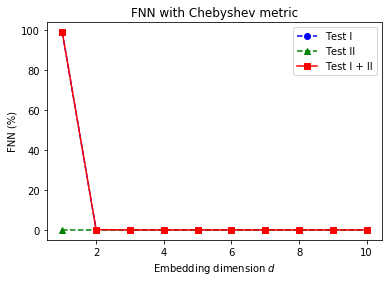

In [91]:
# Generate data.
# x = np.random.normal(size=5000)
dim = np.arange(1, 10 + 1)

plt.figure(1)
f1, f2, f3 = dimension.fnn(series_28[:100000], tau=1, dim=dim, window=10, metric='euclidean')
plt.title(r'FNN with Chebyshev metric')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

# plt.figure(2)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='euclidean')
# plt.title(r'FNN with Euclidean metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.figure(3)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='cityblock')
# plt.title(r'FNN with cityblock (Manhattan) metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.show()

In [10]:
from nolitsa import lyapunov
lyapunov_26 = lyapunov.mle_embed(series_26[:100000], dim=[5], tau=13, maxt=300, window=60)[0]
lyapunov_28 = lyapunov.mle_embed(series_28[:100000], dim=[5], tau=13, maxt=300, window=60)[0]

In [213]:
x, dim=[1], tau=1, window=10, maxt=500,
              metric='euclidean', maxnum=None, parallel=True):

-1.711725320830755

###### 2. Construct an array with indencies to the nearest neighboors and distances to them